In [2]:
import numpy as np
import cv2 as cv
from PIL import Image, ImageEnhance
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,models
import torch.backends.cudnn as cudnn
import matplotlib .pyplot as plt
from itertools import permutations
import os
import random
from sklearn.model_selection import train_test_split


def rotate(x, degree):
    # Rotate the image by degrees counter clockwise
    return x.rotate(degree)

def enh_bri(x, brightness):
    bri = ImageEnhance.Brightness(x)
    return bri.enhance(brightness)

def enh_con(x, contrast):
    con = ImageEnhance.Contrast(x)
    return con.enhance(contrast)

def enh_sha(x, sharpness):
    sha = ImageEnhance.Sharpness(x)
    return sha.enhance(sharpness)

def gaussian(x, kernel_size):
    x = np.array(x)
    x = cv.GaussianBlur(x, kernel_size, sigmaX=0)
    return Image.fromarray(x)

def shear(x, shear_factor):
    # 定义错切变换矩阵
    shear_matrix = [1, shear_factor, 0, 0, 1, 0]

    # 创建Affine对象并应用错切变换
    sheared_img = x.transform(
        x.size, Image.Transform.AFFINE, shear_matrix
    )
    return sheared_img

def translate(x, shift):
    shift_x, shift_y = shift[0], shift[1]
    # 进行平移操作
    translated_img = x.transform(
        x.size, Image.Transform.AFFINE, (1, 0, shift_x, 0, 1, shift_y)
    )
    return translated_img

mrs = [rotate, enh_bri, enh_sha, enh_con, gaussian, shear, translate]
mrs_name =[mr.__name__ for mr in mrs]
print(mrs_name)
paras = [3, 0.8, 0.8, 0.8, (3, 3), 0.1, (1,1)]

class CustomDataset(Dataset):
    def __init__(self, dataset, cmr=None, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []
        for idx, (img, label) in enumerate(dataset):
            if cmr is not None:
                for index in cmr:
                    img = mrs[index](img, paras[index])
            self.data.append(img)
            self.labels.append(label)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data, label = self.data[idx], self.labels[idx]
        if self.transform is not None:
            data = self.transform(data)
        return data, label


['rotate', 'enh_bri', 'enh_sha', 'enh_con', 'gaussian', 'shear', 'translate']


In [3]:
img_dim = 128

caltech256_dataset = datasets.Caltech256(root='data', download=True)
X = [caltech256_dataset[i][0] for i in range(len(caltech256_dataset))]
y = [caltech256_dataset[i][1] for i in range(len(caltech256_dataset))]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=18, stratify=y)

transform = transforms.Compose([
    transforms.Resize((img_dim, img_dim)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()])

train_set = CustomDataset(zip(X_train, y_train), transform=transform)
test_set = CustomDataset(zip(X_test, y_test), transform=transform)

epochs = 50
batch_size = 128
lr = 1e-3
input_size = 3 * 128 * 128
latent_size = 1024

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified


In [4]:
import math
import torch.nn.functional as F

class Conv2dSame(torch.nn.Conv2d):

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ih, iw = x.size()[-2:]

        pad_h = self.calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = self.calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])

        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
        return F.conv2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

# 定义 VAE 模型
class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            Conv2dSame(3, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            Conv2dSame(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            Conv2dSame(128, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*(img_dim//8)*(img_dim//8), latent_size * 2)  # 输出均值和方差
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128*(img_dim//8)*(img_dim//8)),
            nn.ReLU(),
            nn.Unflatten(1, (128, img_dim//8, img_dim//8)),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # 编码
        latent_params = self.encoder(x)
        mu, logvar = torch.chunk(latent_params, 2, dim=1)
        z = self.reparameterize(mu, logvar)

        # 解码
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar


In [5]:
model = VAE(latent_size=latent_size).to(device)

In [6]:
# 训练VAE模型

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='mean')
model.train()

for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        MSE = criterion(recon_batch, data)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = MSE + KLD
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader.dataset)}")

# 评估模型
model.eval()
test_loss = 0.0
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        test_loss += criterion(recon_batch, data).item()

test_loss /= len(test_loader.dataset)
print(f"Test set loss: {test_loss:.4f}")

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'results/SelfOracle/Caltech256_VAE.pth')

In [7]:
import numpy as np
from scipy.stats import gamma

criterion = nn.MSELoss(reduction='mean')
test_set = CustomDataset(zip(X_test, y_test), transform=transform)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

#将训练集的误差存起来
error_testing = np.zeros(len(test_set))

model.load_state_dict(torch.load('results/SelfOracle/Caltech256_VAE.pth'))
model.to(device)
model.eval()
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)
        recon_batch, _, _ = model(data)
        error_testing[i] = criterion(recon_batch, data).cpu().item()

print(error_testing)
#拟合一个分布
shape, loc, scale = gamma.fit(error_testing, floc=0)
false_alarm = 0.0001

#求出上百分之一分位数
threshold = gamma.ppf(1-false_alarm, shape, loc, scale)

print(threshold)
print(np.where(error_testing>threshold)[0].size)



[0.01726231 0.11268657 0.0631999  ... 0.15793899 0.05442735 0.10063644]
0.40455805807087736
0


In [9]:
with open('results/SelfOracle/Caltech256_threshold.txt', 'w') as f:
    f.write(f'False_alarm: {false_alarm}\n')
    f.write(f'Tthreshold: {threshold}\n')

In [6]:
model.load_state_dict(torch.load('results/SelfOracle/Caltech256_VAE.pth'))

<All keys matched successfully>

In [ ]:
test_set = CustomDataset(zip(X_test, y_test))
criterion = nn.MSELoss(reduction='mean')
result_selfOracle = {}
batch_size = 1
model.eval()
model.to(device)
for i in range(len(mrs)):
    for cmr in permutations(range(len(mrs)), i+1):
        result_selfOracle[cmr] = []
        followup_test_set = CustomDataset(test_set, cmr, transform=transform)
        followup_test_loader = DataLoader(followup_test_set, batch_size=batch_size, shuffle=False)
        with torch.no_grad():
            for batch_idx, (data, _) in enumerate(followup_test_loader):
                data = data.to(device)
                recon, _, _ = model(data)
                error = criterion(recon, data)
                result_selfOracle[cmr].append(error.cpu().item())
        print(cmr)

In [8]:
print(type(result_selfOracle))
print(len(result_selfOracle))

np.save('results/SelfOracle/Caltech256_validity.npy', result_selfOracle)

<class 'dict'>
13699


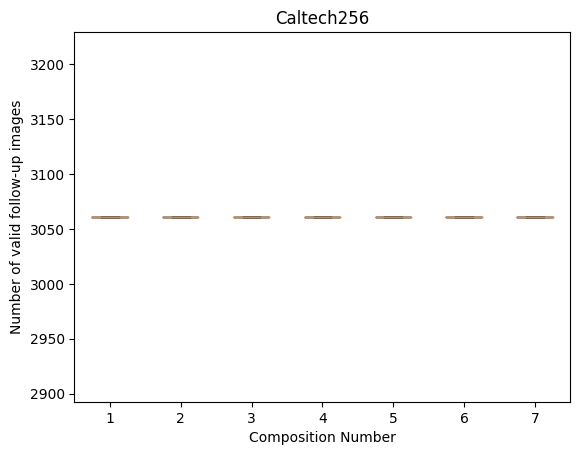

In [6]:
result_selfOracle = np.load('results/SelfOracle/Caltech256_validity.npy', allow_pickle=True).item()
#print(result_selfOracle)

th = 0.40455805807087736
data = [[] for _ in range(len(mrs))]
for cmr in result_selfOracle.keys():
    data[len(cmr)-1].append(len(np.where(np.array(result_selfOracle[cmr])<=th)[0]))
    if len(np.where(np.array(result_selfOracle[cmr])<=th)[0]) != len(result_selfOracle[cmr]):
        print(1)

# 创建箱线图
plt.boxplot(data, patch_artist=False)

# 设置图表标题和轴标签
plt.title('Caltech256')
plt.xlabel('Composition Number')
plt.ylabel('Number of valid follow-up images')

plt.savefig('results/SelfOracle/Caltech256_validity.pdf', dpi=600)

# 显示图表
plt.show()
